### Note: Restarted kernel here to ensure a clean session.

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Set paths
dataset_dir = "/Users/anumdamani/thesis/fiction_images"

# Get all image file paths
all_images = []
all_labels = []

# Iterate through class directories
for class_index, class_name in enumerate(['0_nonbestseller_covers', '1_bestseller_covers']):
    class_dir = os.path.join(dataset_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    all_images.extend(images)
    all_labels.extend([class_index] * len(images))

# Split dataset into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=123
)

# Create TensorFlow Datasets
def create_dataset(image_paths, labels, batch_size=32):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        return img, tf.one_hot(label, depth=2)  # One-hot encoding

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)

# RESNET50

In [2]:
# TRYING RESNET
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Define parameters
img_size = (224, 224)
batch_size = 32 

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pretrained layers

# Add custom classification layers
x = base_model.output  
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(2, activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.2f}")

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 78s 651ms/step - accuracy: 0.7151 - loss: 0.6820 - val_accuracy: 0.8244 - val_loss: 0.4113
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 79s 673ms/step - accuracy: 0.8391 - loss: 0.3776 - val_accuracy: 0.8340 - val_loss: 0.3935
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 83s 707ms/step - accuracy: 0.8584 - loss: 0.3308 - val_accuracy: 0.8383 - val_loss: 0.3900
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 638ms/step - accuracy: 0.8682 - loss: 0.2988 - val_accuracy: 0.8362 - val_loss: 0.3919
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 643ms/step - accuracy: 0.8862 - loss: 0.2748 - val_accuracy: 0.8255 - val_loss: 0.3967
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 646ms/step - accuracy: 0.9016 - loss: 0.2432 - val_accuracy: 0.8373 - val_loss: 0.3959
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 76s 649ms/step - accuracy: 0.9135 - loss: 0.2216 - val_accuracy: 0.8298 - val_loss: 0.4217
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 77s 657ms/step - accuracy: 0.9186 - loss: 0

In [3]:
from sklearn.metrics import classification_report
import numpy as np

# Collect true labels and predictions
y_true, y_pred = [], []

for images, labels in val_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    preds = model.predict(images)  # Get predicted probabilities
    y_pred.extend(np.argmax(preds, axis=1))  # Convert probabilities to class labels

# Print classification report
#print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2025-04-13 20:06:42.794847: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step


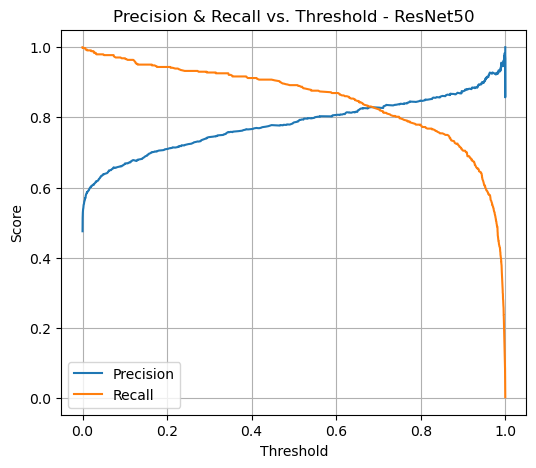

PR curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/resnet50/new/resnet_threshold_curve.png


In [5]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/resnet50/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Get the true labels, as binary
y_true = np.concatenate([y.numpy().argmax(axis=1) for _, y in val_dataset])  # from one-hot to class index

# Get predicted probabilities for class 1
y_probs = model.predict(val_dataset)[:, 1]  # class 1 probs

# Plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - ResNet50')
plt.legend()
plt.grid()
#plt.show()
# Save the figure
pr_curve_path = os.path.join(output_dir, "resnet_threshold_curve.png")
plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
plt.show() 
plt.close()
print(f"PR curve saved at: {pr_curve_path}")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from sklearn.metrics import confusion_matrix

# Get true labels
y_true_val = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_dataset], axis=0)  # Convert one-hot to class indices
y_pred_probs = model.predict(val_dataset)

2025-04-13 20:07:35.756907: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
# Get probabilities for Class 1 only
y_pred_probs_class1 = y_pred_probs[:, 1]
# Set desired threshold
threshold = 0.8
y_pred_custom = (y_pred_probs_class1 >= threshold).astype(int)
# Use the new threshold-based predictions
print("Classification Report with threshold = 0.8:\n")
print(classification_report(y_true_val, y_pred_custom))
# Explanation: 0.8 is best.
# 0.7 gives a balanced result. If increase 0.7 to 0.8, then precision increases from 0.83 to 0.85.
# Recall drops from 0.82 to 0.77.
# increasing from 0.8 to 0.9, precision increases by 0.02 but recall drops by 0.07.

Classification Report with threshold = 0.8:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       490
           1       0.85      0.77      0.81       444

    accuracy                           0.83       934
   macro avg       0.83      0.82      0.83       934
weighted avg       0.83      0.83      0.83       934



30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step


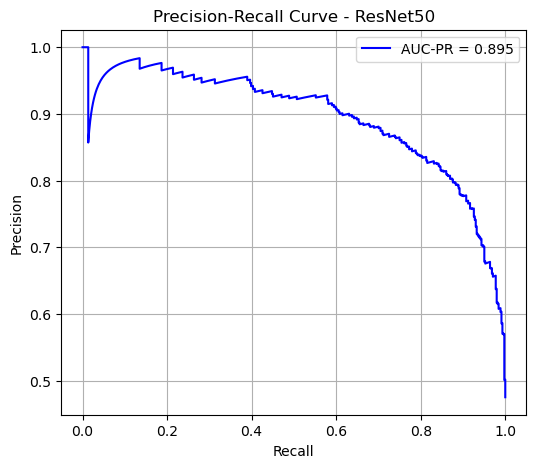

Precision-Recall curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/resnet50/new/resnet50_precision_recall_curve.png


In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import os

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/resnet50/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Get true labels and predicted probabilities
y_true_val = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_dataset], axis=0)
y_pred_probs = model.predict(val_dataset)[:, 1]  # probability for class 1

# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_probs)
avg_precision = average_precision_score(y_true_val, y_pred_probs)

# Plot the precision-recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - ResNet50')
plt.legend(loc='best')
plt.grid()
# Save the plot
prc_path = os.path.join(output_dir, "resnet50_precision_recall_curve.png")
plt.savefig(prc_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"Precision-Recall curve saved at: {prc_path}")

In [12]:
# from sklearn.metrics import classification_report, confusion_matrix

# # Use the new threshold-based predictions
# print("Classification Report with threshold = 0.7:\n")
# print(classification_report(y_true_val, y_pred_custom))

# # Confusion matrix
# conf_matrix_thresh = confusion_matrix(y_true_val, y_pred_custom)

# # plot new confusion matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix_thresh, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix - ResNet50")
# plt.tight_layout()
# plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       490
           1       0.85      0.77      0.81       444

    accuracy                           0.83       934
   macro avg       0.83      0.82      0.83       934
weighted avg       0.83      0.83      0.83       934



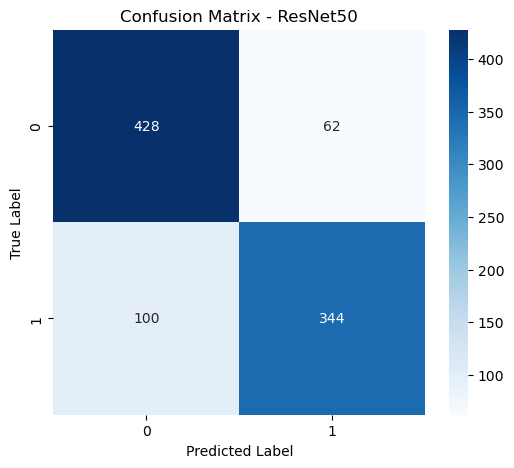

Confusion matrix saved at: /Users/anumdamani/thesis/image_modeling_outputs/resnet50/new/resnet50_confusion_matrix.png


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from sklearn.metrics import confusion_matrix

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/resnet50/new"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_custom)

# Print classification report
print("Classification Report:\n", classification_report(y_true_val, y_pred_custom))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50")

# Save the figure
conf_matrix_path = os.path.join(output_dir, "resnet50_confusion_matrix.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()  # Close plot to free memory
plt.close()
print(f"Confusion matrix saved at: {conf_matrix_path}")

In [14]:
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix - ResNet50")
# plt.show()

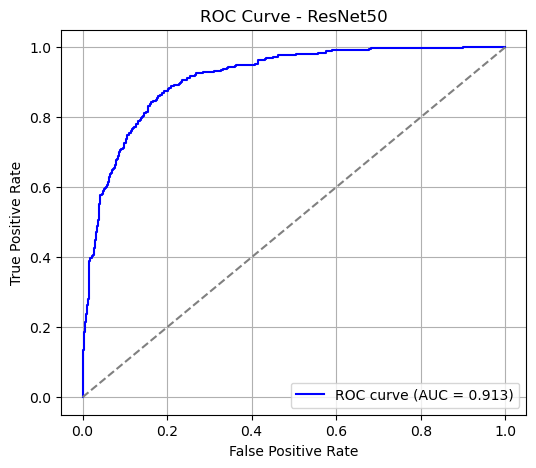

ROC curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/resnet50/new/resnet50_roc_curve.png


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/resnet50/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs)  # Use probabilities of the positive class 
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet50')
plt.legend(loc='best')
plt.grid()
# Save the plot as a .png file
roc_path = os.path.join(output_dir, "resnet50_roc_curve.png")
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
plt.show()  # Close plot to free memory
plt.close()
print(f"ROC curve saved at: {roc_path}")

# MobileNet

### Note: Restarted kernel here to ensure a clean session.

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set paths
dataset_dir = "/Users/anumdamani/thesis/fiction_images"

# Get all image file paths
all_images = []
all_labels = []

# Iterate through class directories
for class_index, class_name in enumerate(['0_nonbestseller_covers', '1_bestseller_covers']):
    class_dir = os.path.join(dataset_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    all_images.extend(images)
    all_labels.extend([class_index] * len(images))

# Split dataset into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=123
)

# Create TensorFlow Datasets
def create_dataset(image_paths, labels, batch_size=16):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224)) / 255.0  # Normalize
        return img, label  # No need for one-hot encoding (binary classification)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)

# Load pre-trained MobileNetV3Small
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze the base model (for transfer learning)
base_model.trainable = False

# Add new layers
x = GlobalAveragePooling2D()(base_model.output)  
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)  # Added dropout for regularization
output_layer = Dense(1, activation="sigmoid")(x)  # Binary classification

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()

# Train model
epochs = 10
model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5838 - loss: 0.6765 - val_accuracy: 0.6756 - val_loss: 0.6181
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6654 - loss: 0.6128 - val_accuracy: 0.6970 - val_loss: 0.5874
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6957 - loss: 0.5910 - val_accuracy: 0.7056 - val_loss: 0.5772
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6946 - loss: 0.5806 - val_accuracy: 0.7066 - val_loss: 0.5690
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.7073 - loss: 0.5768 - val_accuracy: 0.7088 - val_loss: 0.5616
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7058 - loss: 0.5676 - val_accuracy: 0.7099 - val_loss: 0.5557
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7165 - loss: 0.5572 - val_accuracy: 0.7173 - val_loss: 0.5506
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7099 - loss: 0.5589 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

2025-04-13 20:13:56.123466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


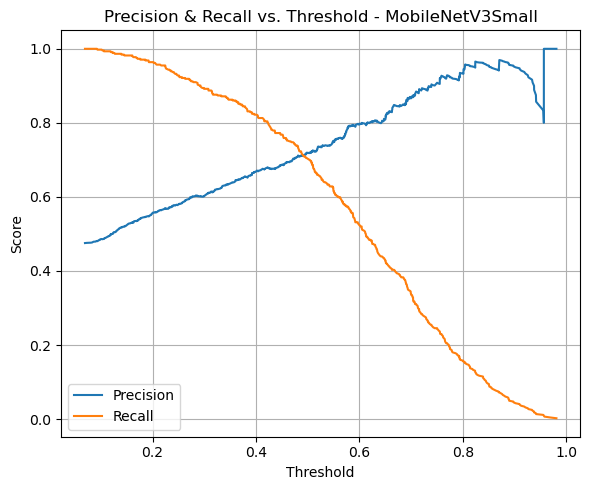

PR curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new/mobilenet_threshold_curve.png


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

# Get predictions
y_true = []
y_pred_probs = []

# Iterate over validation dataset
for images, labels in val_dataset:
    preds = model.predict(images)  # Get probability predictions
    y_pred_probs.extend(preds.flatten())  # Store probabilities
    y_true.extend(labels.numpy())  # Store actual labels
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)

# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - MobileNetV3Small')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.show()
# Save the figure
pr_curve_path = os.path.join(output_dir, "mobilenet_threshold_curve.png")
plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
plt.show() 
plt.close()
print(f"PR curve saved at: {pr_curve_path}")

Classification Report:
                 precision    recall  f1-score   support

Non-Bestseller       0.74      0.75      0.74       490
    Bestseller       0.72      0.70      0.71       444

      accuracy                           0.73       934
     macro avg       0.73      0.73      0.73       934
  weighted avg       0.73      0.73      0.73       934



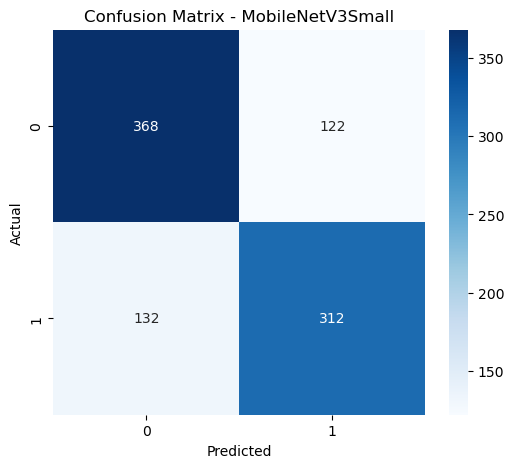

Confusion matrix saved at: /Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new/mobilenet_confusion_matrix.png


In [10]:
# Convert probabilities to binary (threshold = 0.5)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Generate classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Non-Bestseller', 'Bestseller']))

# Explanation: Must keep at 0.5 because increasing to 0.55 or 0.6 leads to too much of a drop in recall (around 0.5-0.6 recall values)

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV3Small")

# Save the figure
conf_matrix_path = os.path.join(output_dir, "mobilenet_confusion_matrix.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()  # Close plot to free memory
plt.close()
print(f"Confusion matrix saved at: {conf_matrix_path}")

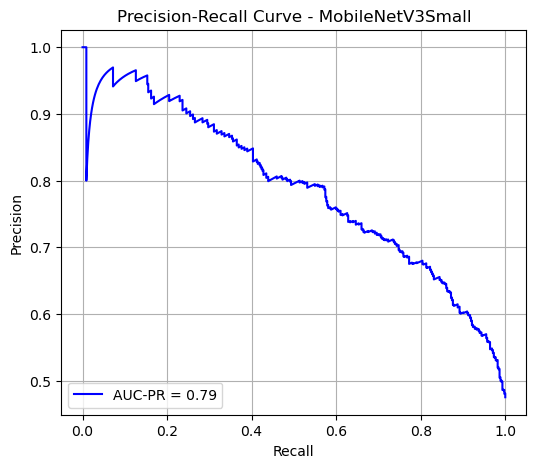

Precision-Recall curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new/mobilenet_precision_recall_curve.png


In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new"
os.makedirs(output_dir, exist_ok=True) 

# Calculate precision, recall, thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_probs)
avg_precision = average_precision_score(y_true, y_pred_probs)

# Plot PR curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MobileNetV3Small')
plt.legend(loc='lower left')
plt.grid()
# Save PR curve
pr_curve_path = os.path.join(output_dir, "mobilenet_precision_recall_curve.png")
plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"Precision-Recall curve saved at: {pr_curve_path}")

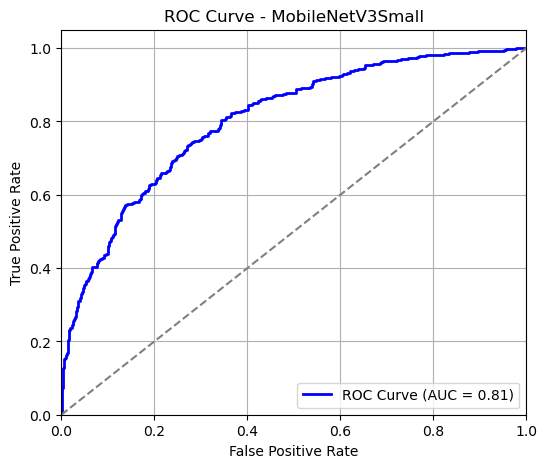

ROC curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new/mobilenet_roc_curve.png


In [12]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)  # Use probability scores
roc_auc = auc(fpr, tpr)

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/mobilenet/new"
os.makedirs(output_dir, exist_ok=True)  

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MobileNetV3Small")
plt.legend(loc="lower right")
plt.grid()
# Save the figure before displaying
roc_curve_path = os.path.join(output_dir, "mobilenet_roc_curve.png")
plt.savefig(roc_curve_path, dpi=300, bbox_inches="tight")
plt.show()  # Close the figure to free memory
plt.close()
print(f"ROC curve saved at: {roc_curve_path}")

# EfficientNetB0

### Note: Restarted kernel here to ensure a clean session.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
from sklearn.model_selection import train_test_split

# Set parameters
img_size = (224, 224)
batch_size = 32
# Set paths
dataset_dir = "/Users/anumdamani/thesis/fiction_images"

# Get all image file paths
all_images = []
all_labels = []

# Iterate through class directories
for class_index, class_name in enumerate(['0_nonbestseller_covers', '1_bestseller_covers']):
    class_dir = os.path.join(dataset_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    all_images.extend(images)
    all_labels.extend([class_index] * len(images))

# Split dataset into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=123
)

# Create TensorFlow Datasets
def create_dataset(image_paths, labels, batch_size=16):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224)) / 255.0  # Normalize
        return img, label  # No need for one-hot encoding (binary classification)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)

# Load EfficientNetB0 without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze entire model
for layer in base_model.layers[:100]:  # Keep first 100 layers frozen
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Use sparse_categorical_entropy if labels are not one-hot encoded
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.2f}")

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 80s 311ms/step - accuracy: 0.6875 - loss: 0.5886 - val_accuracy: 0.5503 - val_loss: 0.7336
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 70s 299ms/step - accuracy: 0.7532 - loss: 0.5022 - val_accuracy: 0.7559 - val_loss: 0.4915
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 70s 299ms/step - accuracy: 0.7789 - loss: 0.4732 - val_accuracy: 0.8137 - val_loss: 0.4312
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 68s 293ms/step - accuracy: 0.7949 - loss: 0.4343 - val_accuracy: 0.7794 - val_loss: 0.4682
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 71s 305ms/step - accuracy: 0.8114 - loss: 0.4138 - val_accuracy: 0.7891 - val_loss: 0.5446
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 70s 298ms/step - accuracy: 0.8289 - loss: 0.3829 - val_accuracy: 0.8233 - val_loss: 0.4369
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 71s 304ms/step - accuracy: 0.8344 - loss: 0.3622 - val_accuracy: 0.8137 - val_loss: 0.4652
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 69s 297ms/step - accuracy: 0.8504 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 19:24:55.052068: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


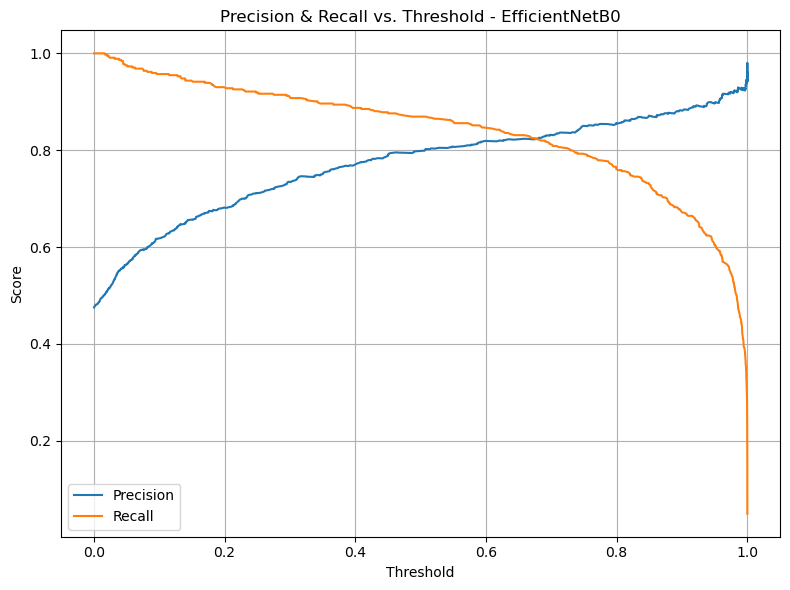

PR curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new/efficientnet_threshold_curve.png


In [4]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
# Get predictions
y_true = []
y_probs = []

for images, labels in val_dataset:
    preds = model.predict(images).flatten()  # Probabilities
    y_probs.extend(preds)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - EfficientNetB0')
plt.legend()
plt.grid()
plt.tight_layout()

# Save and show the plot
pr_curve_path = os.path.join(output_dir, "efficientnet_threshold_curve.png")
plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"PR curve saved at: {pr_curve_path}")

In [15]:
# Apply custom threshold
threshold = 0.75 
y_pred = [1 if prob >= threshold else 0 for prob in y_probs]

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Non-Bestseller", "Bestseller"]))
# Explanation: 0.75 is the best threshold. Increasing from 0.75 to 0.8, precision increases from 0.85 to 0.86.
# recall drops from 0.79 to 0.76. F1-score drops from 0.82 to 0.80. So best to keep it at 0.75

                precision    recall  f1-score   support

Non-Bestseller       0.82      0.87      0.85       490
    Bestseller       0.85      0.79      0.82       444

      accuracy                           0.83       934
     macro avg       0.84      0.83      0.83       934
  weighted avg       0.83      0.83      0.83       934



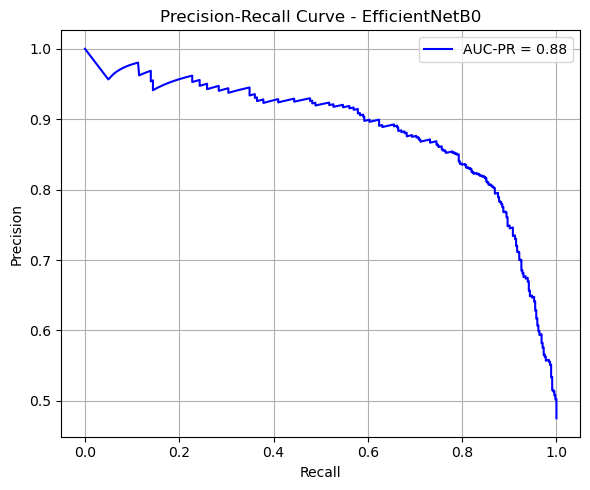

In [17]:
import os
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
average_precision = average_precision_score(y_true, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - EfficientNetB0')
plt.legend()
plt.grid()
plt.tight_layout()
# Save the figure
conf_matrix_path = os.path.join(output_dir, "efficientnetb0_pr_curve.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  

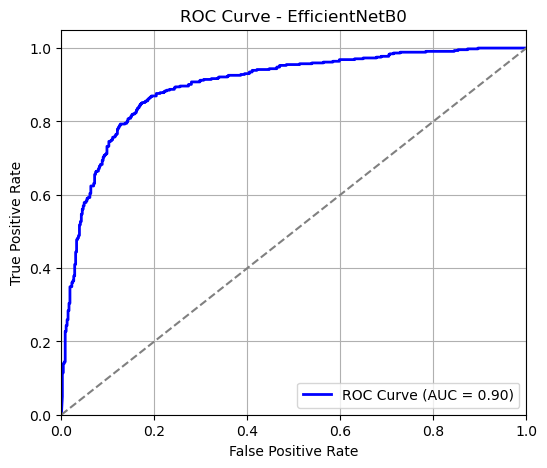

ROC curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new/efficientnetb0_roc_curve.png


In [24]:
from sklearn.metrics import roc_curve, auc

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

fpr, tpr, _ = roc_curve(y_true, y_probs)  # Use probability scores
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EfficientNetB0")
plt.legend(loc="lower right")
plt.grid()
# Save the figure before displaying
roc_curve_path = os.path.join(output_dir, "efficientnetb0_roc_curve.png")
plt.savefig(roc_curve_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  # Close the figure to free memory

print(f"ROC curve saved at: {roc_curve_path}")

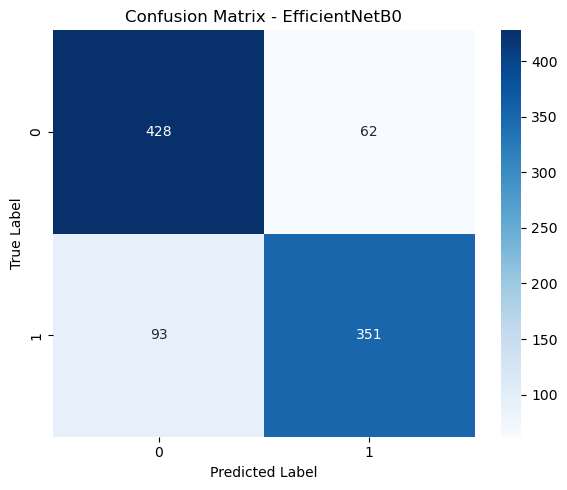

Confusion matrix saved at: /Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new/efficientnetb0_confusion_matrix.png


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/efficientnetb0/new"
os.makedirs(output_dir, exist_ok=True)  

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["0", "1"],
            yticklabels=["0", "1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - EfficientNetB0')
plt.tight_layout()
# Save the figure
conf_matrix_path = os.path.join(output_dir, "efficientnetb0_confusion_matrix.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  # Close plot to free memory

print(f"Confusion matrix saved at: {conf_matrix_path}")

# VGG16

### Note: Restarted kernel here to ensure a clean session.

In [1]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# Set paths
dataset_dir = "/Users/anumdamani/thesis/fiction_images"

# Get all image file paths and labels
all_images = []
all_labels = []

# Iterate through class directories
for class_index, class_name in enumerate(['0_nonbestseller_covers', '1_bestseller_covers']):
    class_dir = os.path.join(dataset_dir, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    all_images.extend(images)
    all_labels.extend([class_index] * len(images))

# Split dataset into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=123
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

# Function to preprocess an image for VGG16
def preprocess_image_vgg(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Resize image
    image = img_to_array(image)  # Convert to NumPy array
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = preprocess_input(image)  # Preprocess for VGG16
    return image

# Function to extract features from images using VGG16
def extract_image_features(image_paths):
    features = []
    for image_path in image_paths:
        image = preprocess_image_vgg(image_path)
        feature = base_model.predict(image)  # Get feature map from VGG16
        features.append(feature.flatten())  # Flatten feature map
    return np.array(features)

# Extract image features for training and validation sets
X_train = extract_image_features(train_images)
X_test = extract_image_features(val_images)
y_train = np.array(train_labels)
y_test = np.array(val_labels)

# Define a simple neural network for classification
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

/Users/anumdamani/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6995 - loss: 13.0240 - val_accuracy: 0.7730 - val_loss: 0.7644
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8369 - loss: 0.4163 - val_accuracy: 0.8158 - val_loss: 0.4898
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8882 - loss: 0.2674 - val_accuracy: 0.8233 - val_loss: 0.4686
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9312 - loss: 0.1878 - val_accuracy: 0.8201 - val_loss: 0.5082
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9429 - loss: 0.1516 - val_accuracy: 0.8126 - val_loss: 0.5986
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9512 - loss: 0.1390 - val_accuracy: 0.8201 - val_loss: 0.5840
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9554 - loss: 0.1200 - val_accuracy: 0.8276 - val_loss: 0.6423
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9600 - loss: 0.1155 - val_accuracy: 0.81

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


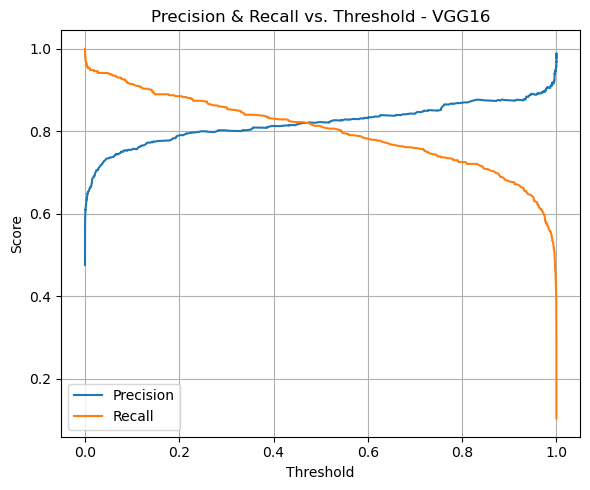

PR curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/vgg16/new/vgg16_threshold_curve.png


In [2]:
from sklearn.metrics import precision_recall_curve
# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/vgg16/new"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Get predicted probabilities (not class labels)
y_probs = model.predict(X_test).flatten()  

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall vs threshold curve
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - VGG16')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the figure
pr_curve_path = os.path.join(output_dir, "vgg16_threshold_curve.png")
plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
plt.show() 
plt.close()
print(f"PR curve saved at: {pr_curve_path}")

In [19]:
# Predict on validation data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.55).astype(int)  # Convert probabilities to binary labels

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Explanation: 0.55 is best threshold. Increasing from 0.55 to 0.6 leads to no increase in precision
# and a 0.02 drop in recall.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       490
           1       0.83      0.80      0.81       444

    accuracy                           0.82       934
   macro avg       0.82      0.82      0.82       934
weighted avg       0.82      0.82      0.82       934



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


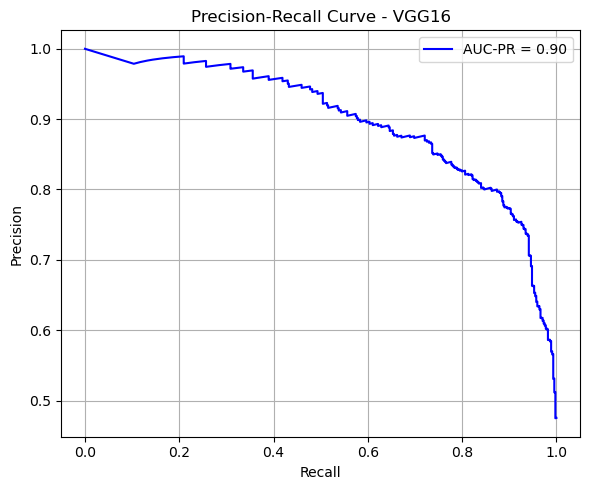

In [22]:
import os
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = y_test  
y_probs = model.predict(X_test) 

# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/vgg16/new"
os.makedirs(output_dir, exist_ok=True)  

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
average_precision = average_precision_score(y_true, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - VGG16')
plt.legend()
plt.grid()
plt.tight_layout()
# Save the figure
conf_matrix_path = os.path.join(output_dir, "vgg16_pr_curve.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  

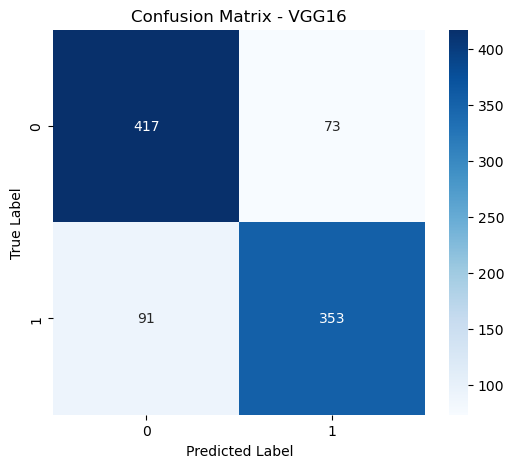

Confusion matrix saved at: /Users/anumdamani/thesis/image_modeling_outputs/vgg16/new/vgg16_confusion_matrix.png


In [23]:
# Define output directory
output_dir = "/Users/anumdamani/thesis/image_modeling_outputs/vgg16/new"
os.makedirs(output_dir, exist_ok=True) 

# Compute and plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VGG16")

# Save the figure
conf_matrix_path = os.path.join(output_dir, "vgg16_confusion_matrix.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  
print(f"Confusion matrix saved at: {conf_matrix_path}")

In [24]:
# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {final_accuracy:.4f}")

Final Accuracy: 0.8244


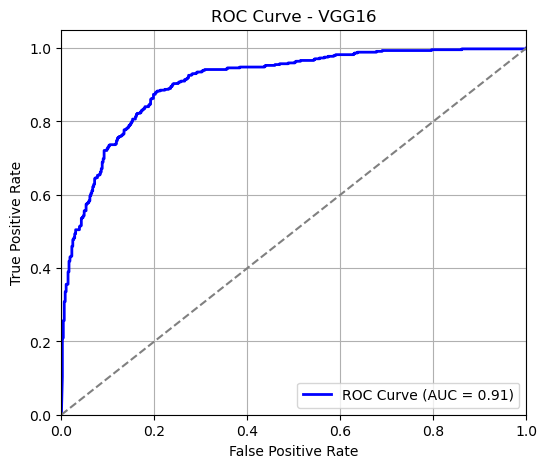

ROC curve saved at: /Users/anumdamani/thesis/image_modeling_outputs/vgg16/new/vgg16_roc_curve.png


In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)  # Use predicted probabilities
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VGG16")
plt.legend(loc="lower right")
plt.grid()
# Save ROC curve figure
roc_curve_path = os.path.join(output_dir, "vgg16_roc_curve.png")
plt.savefig(roc_curve_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()  # Free memory

print(f"ROC curve saved at: {roc_curve_path}")